In [1]:
import os, re, html2text, markdown
import requests as req
import seaborn as sns
import hypertools as hyp
import pandas as pd
import numpy as np
from downloader import download_file_from_google_drive as dl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def wipe_formatting(script, rehtml=False):
    parser = html2text.HTML2Text()
    parser.wrap_links = True
    parser.skip_internal_links = True
    parser.inline_links = True
    parser.ignore_anchors = True
    parser.ignore_images = True
    parser.ignore_emphasis = True
    parser.ignore_links = True
    text = parser.handle(script)
    text = text.strip(' \t\n\r')
    if rehtml:
        text = text.replace('\n', '<br/>')
        text = text.replace('\\', '')
    text = text.replace('\n', ' ').replace('\t', ' ').replace('  ', ' ').replace('  ', ' ')
    return text

In [3]:
def wipe_pointers(line):
    if len(re.findall('\([\w\s]+\)',line)) > 0:
        start, end = re.search('\([\w\s+]+\)',line).span()
        line = line[0:start] + line[end+1:]
    return line

## Load data

In [4]:
fileid = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'
datadir = 'data'
fname = os.path.join(datadir, 'data.csv')

if not os.path.exists(datadir):
    os.makedirs(datadir)
    
if not os.path.exists(fname):
    print('Fetching file from the interwebz!')
    dl(fileid, fname)
else:
    print('Data found!')

Data found!


In [5]:
data = pd.read_csv(fname)

In [6]:
data.head()

,id,title,url,writers,genres,script
0,1,10 Things I Hate About You,http://www.imsdb.com/scripts/10-Things-I-Hate-...,Karen McCullah Lutz;Kirsten Smith;William Shak...,Comedy;Romance,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
1,2,12,http://www.imsdb.com/scripts/12.html,Lawrence Bridges,Comedy,\n\n \n 12 - Script\n
2,3,12 and Holding,http://www.imsdb.com/scripts/12-and-Holding.html,Anthony Cipriano,Drama,\n \n \n ...
3,4,12 Monkeys,http://www.imsdb.com/scripts/12-Monkeys.html,David Peoples;Janet Peoples,Drama;Sci-Fi;Thriller,\n\n\n<b><!--\n</b>if (window!= top)\ntop.loca...
4,5,12 Years a Slave,http://www.imsdb.com/scripts/12-Years-a-Slave....,John Ridley,Drama,\r\n\r\n\r\n 12 YE...


## Select movie

In [19]:
movie = 3
some_script = data.iloc[movie]['script'][1000:3000]
full_script = data.iloc[movie]['script']
movie_title = data.loc[movie,'title']
print('Movie: %s'%movie_title)

Movie: 12 Monkeys


## Find dialogue

In [8]:
# Scrape all characters -- only works for 15 minutes / 12 monkeys!!
pattern = '\n\n\t\t\t\t([ABCDEFGHIJKLMNOPQRSTUVWXYZ]+)\n\t\t'
character_list = pd.DataFrame(re.findall(pattern,full_script))[0].unique()
character_list.sort()
character_list

array(['ASTPOPHYSICIST', 'ASTROPHYSICIST', 'BEN', 'BILLINGS', 'BIOLOGIST',
       'BOTANIST', 'BRUNETTE', 'CAPTAIN', 'CLERK', 'COLE', 'DETECTIVE',
       'DOCTOR', 'ENGINEER', 'EVANGELIST', 'FALE', 'FRANKI', 'GEOLOGIST',
       'GOINES', 'ICHIOKA', 'JEFFREY', 'JOSE', 'KWESKIN', 'LOUIE',
       'LOUIS', 'MAN', 'MARILOU', 'MICROBIOLOGIST', 'MOTHER', 'PATIENT',
       'PILOT', 'POET', 'RAILLY', 'SANDY', 'SCARFACE', 'SCIENTISTS',
       'SERGEANT', 'TEDDY', 'TERRY', 'TINY', 'TRAVELER', 'WALLACE',
       'WAYNE', 'WELLER', 'ZOOLOGIST'], dtype=object)

In [9]:
# MERGE DUPLICATE CHARACTERS WITH SPELLING ERROR -- to be edited

# character_list_out = character_list.copy()
# for li,left in enumerate(character_list):
#     for ri,right in enumerate(character_list):
#         if len(left) == len(right):
#             overlap = sum([left[k]==right[k] for k in range(len(left))])/len(left)
#             if (overlap > .85) & (overlap < 0.999):
#                 character_list_out[li] = 'REMOVE'

## Collect lines per character

In [10]:
char_lines = pd.DataFrame(columns=['character','line_index','loc','line','length'])
for character in character_list:
    print(character)
    pattern = '\n\n\t\t\t\t%s\n\t\t'%character
    dialogue_headers = re.finditer(pattern,full_script)
    dialogue_start_points = []
    for dh in dialogue_headers:
        dialogue_start_points.append(dh.span()[1])
    for spi,sp in enumerate(dialogue_start_points):
        ep = re.search('\n\n\t',full_script[sp:]).span()[0]
        line = full_script[(sp):(sp+ep)]
        line = wipe_formatting(line)
        line = wipe_pointers(line)
        char_lines_tmp = pd.DataFrame([[character, spi, sp, line, len(line)]],
                                      columns=char_lines.columns)
        char_lines = char_lines.append(char_lines_tmp)
char_lines = char_lines.reset_index(drop=True)

ASTPOPHYSICIST
ASTROPHYSICIST
BEN
BILLINGS
BIOLOGIST
BOTANIST
BRUNETTE
CAPTAIN
CLERK
COLE
DETECTIVE
DOCTOR
ENGINEER
EVANGELIST
FALE
FRANKI
GEOLOGIST
GOINES
ICHIOKA
JEFFREY
JOSE
KWESKIN
LOUIE
LOUIS
MAN
MARILOU
MICROBIOLOGIST
MOTHER
PATIENT
PILOT
POET
RAILLY
SANDY
SCARFACE
SCIENTISTS
SERGEANT
TEDDY
TERRY
TINY
TRAVELER
WALLACE
WAYNE
WELLER
ZOOLOGIST


##### Compute cumulative per character

In [11]:
for character in character_list:
    char_lines.loc[char_lines['character']==character,'cumul_length'] = (
        np.cumsum(char_lines.loc[char_lines['character']==character,'length']))

In [12]:
char_lines.head()

,character,line_index,loc,line,length,cumul_length
0,ASTPOPHYSICIST,0,10156,"Where you collected sample #4, what street was...",52,52
1,ASTROPHYSICIST,0,9580,We want you to tell us about last night.,40,40
2,ASTROPHYSICIST,1,12808,"Wake up, Cole.",14,54
3,ASTROPHYSICIST,2,13398,To be determined by the proper authorities.,43,97
4,ASTROPHYSICIST,3,13583,"We have a very advanced program, something ver...",88,185


In [13]:
# Merge misspelled names --- 12 monkeys only

# char_lines['character'] = char_lines['character'].replace(to_replace={
#     'ASTPOPHYSICIST':'ASTROPHYSICIST'})
# char_lines.loc[char_lines['character']=='ASTROPHYSICIST','line_index'] = (
#     np.arange(len(char_lines.loc[char_lines['character']=='ASTROPHYSICIST','line_index'])))
# character_list = char_lines['character'].unique()
# character_list.sort()

## Rank characters by amount of dialogue

In [14]:
total_dialogue_per_character = char_lines[['character','length']].groupby(['character']).sum(
    ).sort_values(by='length',ascending = False).reset_index()
total_dialogue_per_character['share'] = (total_dialogue_per_character['length'].values / 
                                        np.sum(total_dialogue_per_character['length']))
total_dialogue_per_character.head()

,character,length,share
0,COLE,14437,0.295320
1,RAILLY,11083,0.226711
2,JEFFREY,10477,0.214315
3,FALE,1849,0.037823
4,ASTROPHYSICIST,1034,0.021151


## Visualize development of lines per character - top-n

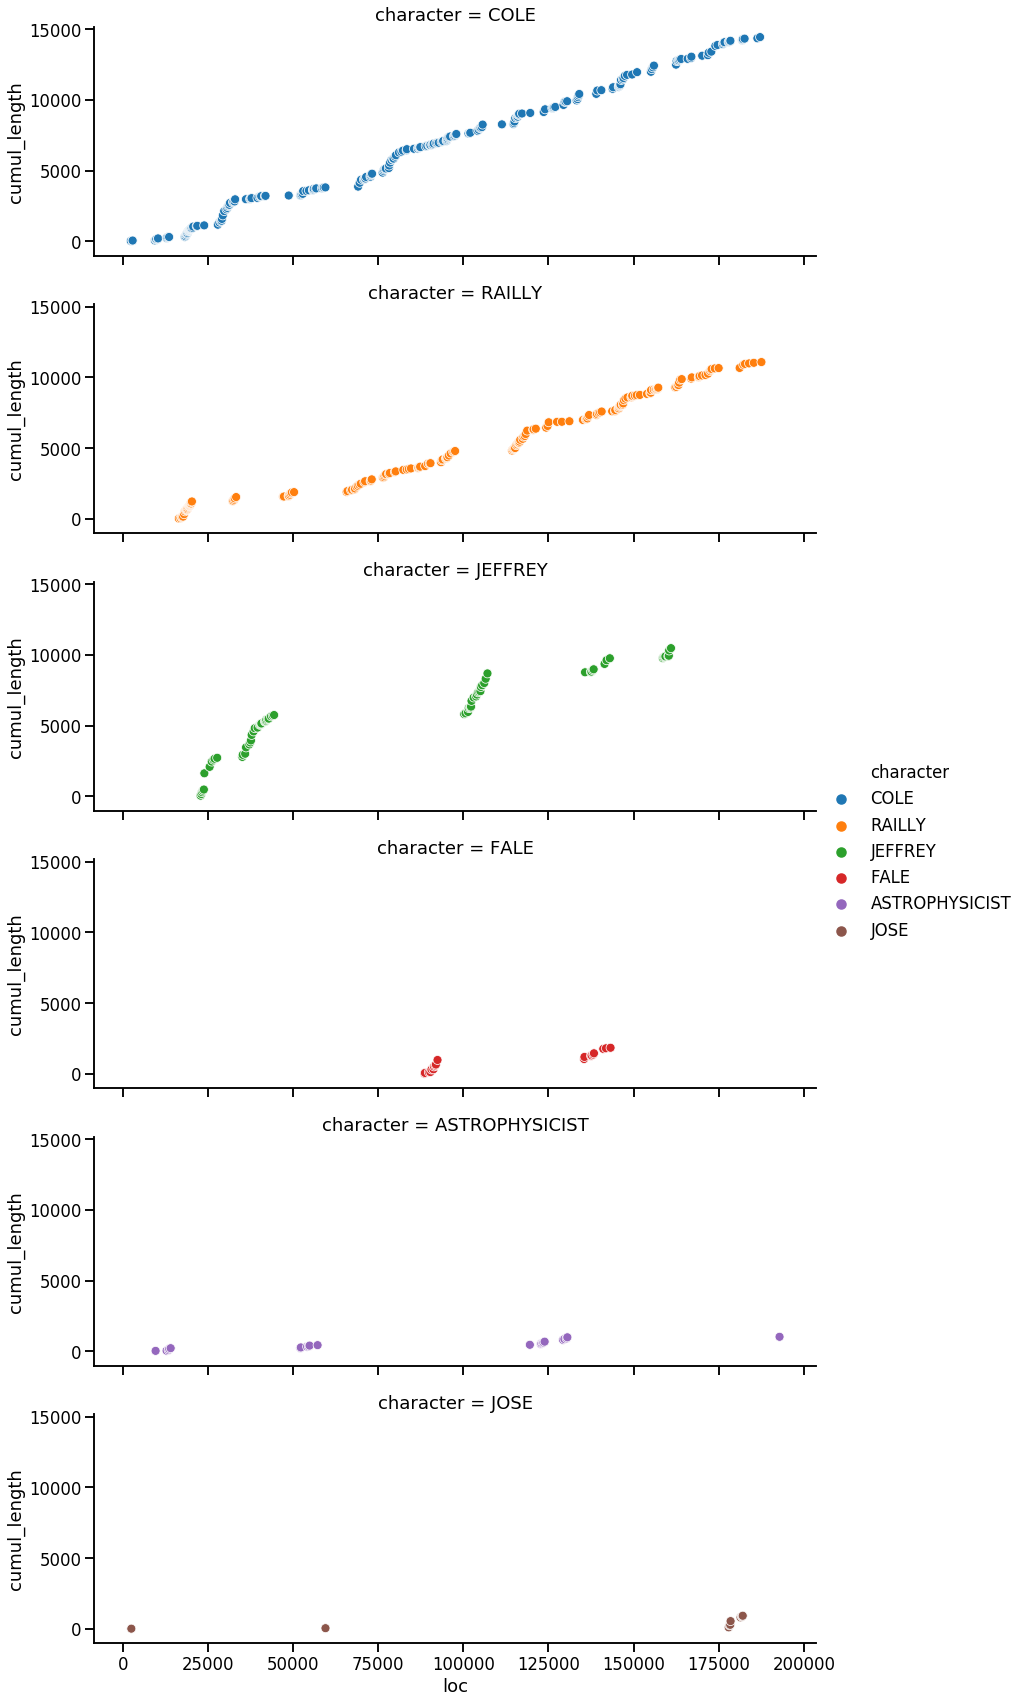

In [15]:
sns.set_context('talk')
n_characters = 5
char_order = total_dialogue_per_character.loc[:n_characters,'character']
sns.relplot(data = char_lines.loc[char_lines['character'].isin(
    total_dialogue_per_character.loc[:n_characters,'character']),:],
    x = 'loc', y = 'cumul_length', row = 'character', row_order = char_order,
    hue = 'character', hue_order = char_order, height = 4, aspect = 3)

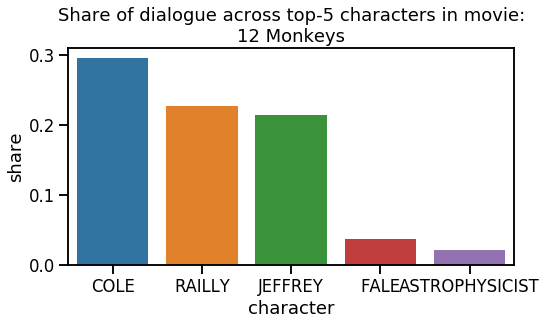

In [23]:
fig, ax = plt.subplots(1,1,figsize=[8,4])
sns.barplot(data = total_dialogue_per_character.iloc[0:n_characters,:],
            x = 'character', y = 'share', ax = ax)
ax.set(title = 'Share of dialogue across top-%i characters in movie:\n%s'%(
    n_characters,movie_title));
plt.savefig('figures/Share_dialogue_%s.pdf'%movie_title,bbox_inches='tight')

In [29]:
fullScript

'\n\n\n<b><!--\n</b>if (window!= top)\ntop.location.href=location.href\n<b>// -->\n</b>\nTwelve Monkeys\n\n\n\t\t\t\tTWELVE MONKEYS\n\t    \n\t\t          An original screenplay by\n\n\t\t\t\tDavid Peoples\n  \t\t\t\t     &\n\t\t\t\tJanet Peoples\n\n\t\t\t\t Inspired by\n\t    \n\t\t\tLA JETEE, a Chris Marker Film\n\n\n\n\n\n\tProduction Draft\n\tJune 27, 1994\n\n\n\n\n\n\n\n\n\tFADE IN:\n\n\tINT.  CONCOURSE/AIRPORT TERMINAL - BAY\n\n\tCLOSE ON A FACE.  A nine year old boy, YOUNG COLE, his eyes wide\n\twith wonder. watching something intently.  We HEAR the sounds of\n\tthe P.A. SYSTEM droning Flight Information mingled with the\n\tsounds of urgent SHOUTS, running FEET, EXCLAMATIONS.\n\n\tYOUNG COLE\'S POV:  twenty yards away, a BLONDE MAN is sprawled on\n\tthe floor, blood oozing from his gaudy Hawaiian shirt.\n\n\tA BRUNETTE in a tight dress, her face obscured from YOUNG COLE\'S\n\tview, rushes to the injured man, kneels beside him, ministering\n\tto his wound.\n\n\tANGLE ON YOUNG COL